In [1]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
MHz = 2 * jnp.pi
kHz = 2 * jnp.pi / 1e3
us = 1

In [24]:
Na, Nb = 20, 8

kappa_a = 1 / (100 * us)
kappa_b = 15 * MHz
g2 = 1 * MHz
alpha_m_2 = 10
lam = 1.0
kerr = 20 * kHz
kerr_buffer = 0 * MHz
cross_kerr = 0 * MHz
delta_a = 0 * MHz
delta_b = 0 * MHz

gl = lam * g2
g3 = gl * (0.3 / 0.1) ** 2
epsilon_d = alpha_m_2 * g2

kappa_2 = 4 * g2**2 / kappa_b
print(f"kappa_2 = {kappa_2/MHz:.2f} MHz")

epsilon_d_re = jnp.linspace(-1, 1, 21) * epsilon_d
epsilon_d_im = jnp.linspace(-1, 1, 21) * epsilon_d

a, b = dq.destroy(Na, Nb)

tmax = 5 / kappa_2
nt = 101

tsave = jnp.linspace(0, tmax, nt)

rho_0 = dq.tensor(dq.fock(Na, 0), dq.fock(Nb, 0))

kappa_2 = 0.27 MHz


In [25]:
def H_drives(eps_re, eps_im, a, b):
    H = g2 * dq.dag(a) @ dq.dag(a) @ b
    H += (eps_re + 1j * eps_im) * b
    H += gl * dq.dag(a) @ a @ b
    H += g3 * dq.dag(b) @ b @ b
    H += dq.dag(H)
    H += kerr * dq.dag(a) @ dq.dag(a) @ a @ a / 2
    H += kerr_buffer * dq.dag(b) @ dq.dag(b) @ b @ b / 2
    H += cross_kerr * dq.dag(a) @ a @ dq.dag(b) @ b / 2
    H += delta_a * dq.dag(a) @ a
    H += delta_b * dq.dag(b) @ b
    return H

In [26]:
H = H_drives(
    epsilon_d_re[:, None, None, None],
    epsilon_d_im[None, :, None, None],
    a[None, None, :, :],
    b[None, None, :, :],
)

In [29]:
max_batching = 20

results = jnp.zeros((len(epsilon_d_re) * len(epsilon_d_im), 3, nt), dtype=complex)
H_flattened = H.reshape(-1, Na * Nb, Na * Nb)
cutted_Hs = jnp.array_split(
    H_flattened, jnp.ceil(len(epsilon_d_re) * len(epsilon_d_im) / max_batching)
)
length_cutted = jnp.array([len(el) for el in cutted_Hs])
indexes = jnp.concatenate((jnp.array([0]), jnp.cumsum(length_cutted)))

for ind_per, subH in enumerate(cutted_Hs):
    output = dq.mesolve(
        subH,
        [jnp.sqrt(kappa_a) * a, jnp.sqrt(kappa_b) * b],
        rho_0,
        tsave,
        exp_ops=[
            dq.dag(a) @ a,
            a @ dq.dag(a) - dq.dag(a) @ a,
            b @ dq.dag(b) - dq.dag(b) @ b,
        ],
    )
    results = results.at[indexes[ind_per] : indexes[ind_per + 1]].set(output.expects)
results = results.reshape(len(epsilon_d_re), len(epsilon_d_im), 3, nt)

100.00%|███████████████████████████████████████████████████████████████████| [00:04<00:00, 20.26%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:04<00:00, 20.06%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:05<00:00, 19.84%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:05<00:00, 19.48%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:05<00:00, 19.60%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:05<00:00, 19.81%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:05<00:00, 19.58%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:05<00:00, 19.31%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:05<00:00, 19.12%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:05<00:00, 

/tmp/ipykernel_4327/3999416169.py:9: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(im, ax=ax[1])
/tmp/ipykernel_4327/3999416169.py:11: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(im, ax=ax[2])


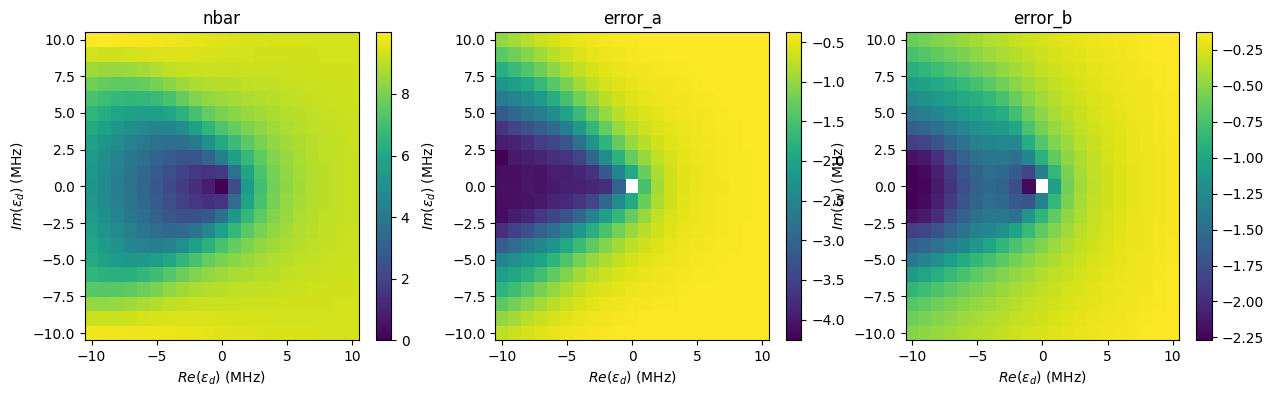

In [ ]:
nbars = results[:, :, 0, -1].real
error_a = jnp.max(jnp.abs(results[:, :, 1] - 1), axis=-1)
error_b = jnp.max(jnp.abs(results[:, :, 2] - 1), axis=-1)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
im = ax[0].pcolor(epsilon_d_re / MHz, epsilon_d_im / MHz, nbars.T)
fig.colorbar(im, ax=ax[0])
im = ax[1].pcolor(epsilon_d_re / MHz, epsilon_d_im / MHz, jnp.log10(error_a.T))
fig.colorbar(im, ax=ax[1])
im = ax[2].pcolor(epsilon_d_re / MHz, epsilon_d_im / MHz, jnp.log10(error_b.T))
fig.colorbar(im, ax=ax[2])

for a, t in zip(ax, ["nbar", "error_a", "error_b"]):
    a.set_xlabel("$Re(\epsilon_d)$ (MHz)")
    a.set_ylabel("$Im(\epsilon_d)$ (MHz)")
    a.set_title(t)

# Right eigenvectors

In [5]:
import dynamiqs as dq
import matplotlib.pyplot as plt
import numpy as np

In [97]:
alpha_2 = 4
lam = 1
N = 50

a = dq.destroy(N)
L = a @ a - alpha_2 * dq.eye(N) + lam * dq.dag(a) @ a

lindbl = dq.slindbladian(dq.zero(N), [L])

In [98]:
w, P = np.linalg.eig(lindbl)
ind_sort = np.argsort(w.real)[::-1]
w, P = w[ind_sort], P[:, ind_sort]
print("Right eigenvectors done")
wp, Pp = np.linalg.eig(lindbl.conj().T)
ind_sort = np.argsort(wp.real)[::-1]
wp, Pp = wp[ind_sort], Pp[:, ind_sort]
print("Left eigenvectors done")

Right eigenvectors done
Left eigenvectors done


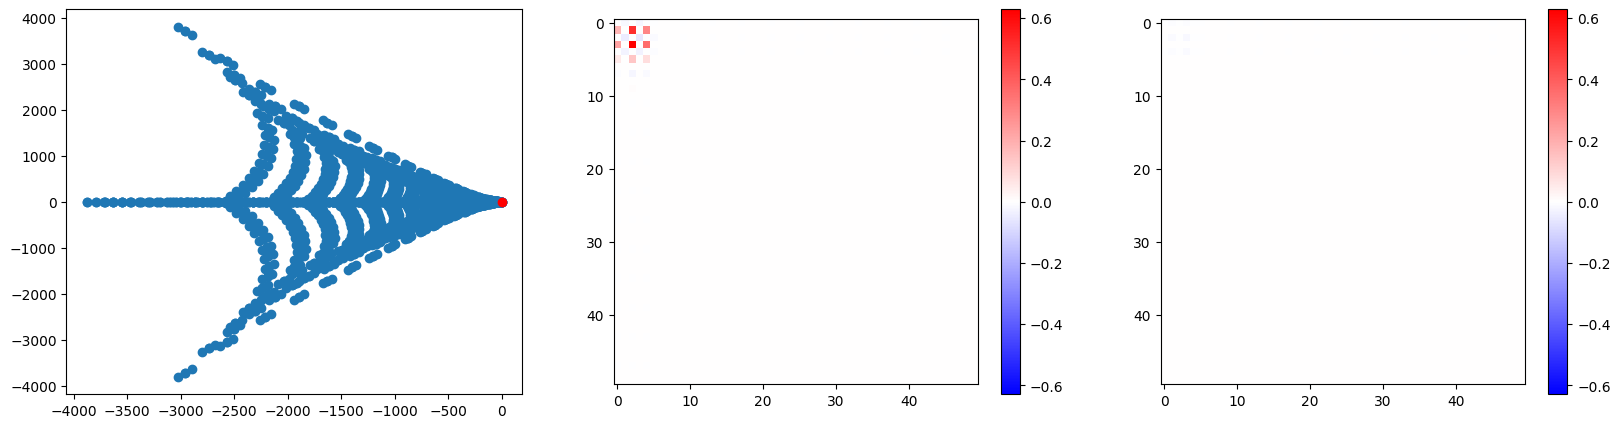

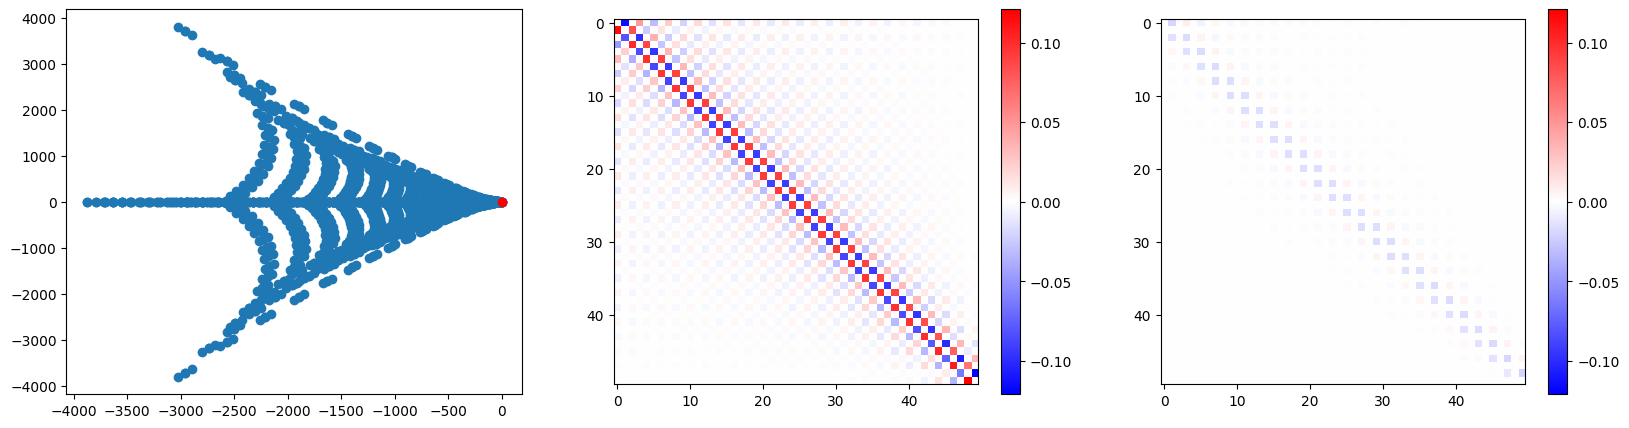

In [117]:
ind = 2
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(w.real, w.imag, "o")
ax[0].plot(w[ind].real, w[ind].imag, "ro")
extr = np.max(np.abs(P[:, ind]))
im = ax[1].imshow(
    P[:, ind].reshape(N, N).real,
    interpolation="none",
    vmin=-extr,
    vmax=extr,
    cmap="bwr",
)
fig.colorbar(im, ax=ax[1])
im = ax[2].imshow(
    P[:, ind].reshape(N, N).imag,
    interpolation="none",
    vmin=-extr,
    vmax=extr,
    cmap="bwr",
)
fig.colorbar(im, ax=ax[2])
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(wp.real, wp.imag, "o")
ax[0].plot(wp[ind].real, wp[ind].imag, "ro")
extr = np.max(np.abs(Pp[:, ind]))
im = ax[1].imshow(
    Pp[:, ind].reshape(N, N).real,
    interpolation="none",
    vmin=-extr,
    vmax=extr,
    cmap="bwr",
)
fig.colorbar(im, ax=ax[1])
im = ax[2].imshow(
    Pp[:, ind].reshape(N, N).imag,
    interpolation="none",
    vmin=-extr,
    vmax=extr,
    cmap="bwr",
)
fig.colorbar(im, ax=ax[2])
plt.show()